‚úÖ Donn√©es fusionn√©es : 4966
‚úÖ Donn√©es enrichies : 2814
üìä Pays filtr√©s : 58


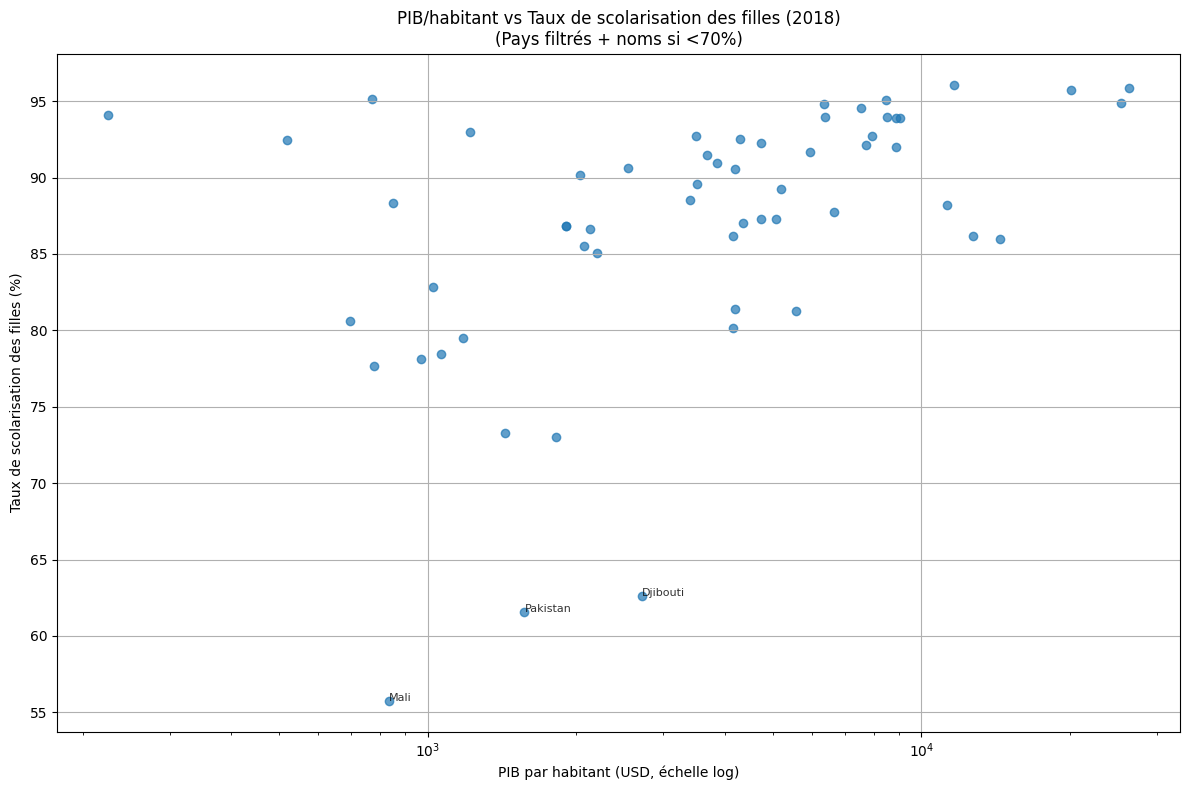

üìà Corr√©lation (2018) : 0.417


<ipython-input-12-d7d9a8a626e8>:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


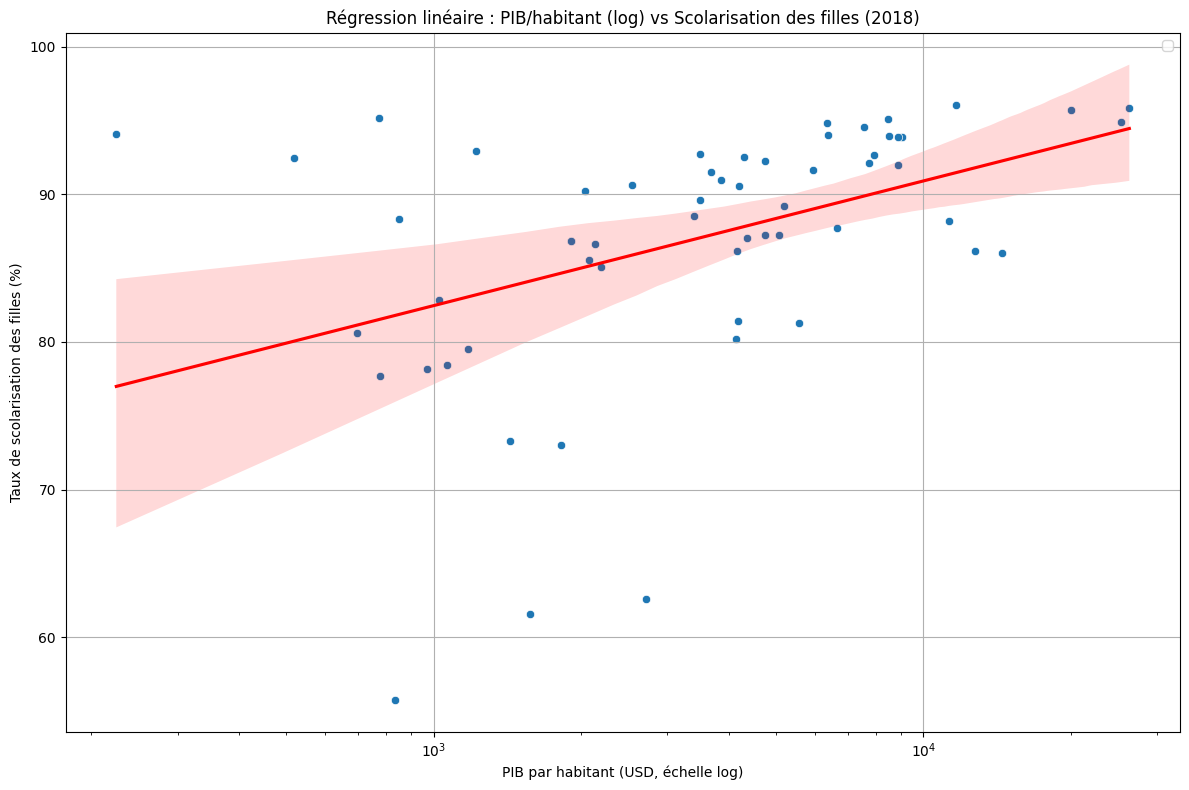

üìä Coefficients du mod√®le :
  - log_GDP_per_capita : 3.529
  - public_edu_spending : 1.153
üîÅ Interception : 53.83
üìê R¬≤ (r√©gression multiple) : 0.213


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

# ----------------------------
# 1. Chargement des fichiers
# ----------------------------
df_pib = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_85121.csv", skiprows=4)
df_edu = pd.read_csv("API_SE.PRM.NENR.FE_DS2_en_csv_v2_87242.csv", skiprows=4)
df_exp = pd.read_csv("API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_85113.csv", skiprows=4)

# ----------------------------
# 2. Transformation format long
# ----------------------------
df_pib_melted = df_pib.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="GDP_per_capita")
df_edu_melted = df_edu.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="Enrollment_rate_female")
df_exp_melted = df_exp.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Public_edu_expenditure_pct_GDP"
)


# ----------------------------
# 3. Nettoyage
# ----------------------------
df_pib_clean = df_pib_melted[["Country Name", "Year", "GDP_per_capita"]].copy()
df_edu_clean = df_edu_melted[["Country Name", "Year", "Enrollment_rate_female"]].copy()

df_pib_clean.dropna(inplace=True)
df_edu_clean.dropna(inplace=True)

df_pib_clean["Year"] = df_pib_clean["Year"].astype(int)
df_edu_clean["Year"] = df_edu_clean["Year"].astype(int)

df_exp_clean = df_exp_melted[["Country Name", "Year", "Public_edu_expenditure_pct_GDP"]].copy()
df_exp_clean.dropna(inplace=True)
df_exp_clean["Year"] = df_exp_clean["Year"].astype(int)

# ----------------------------
# 4. Fusion des deux jeux de donn√©es
# ----------------------------
df_merged = pd.merge(df_pib_clean, df_edu_clean, on=["Country Name", "Year"])
print("‚úÖ Donn√©es fusionn√©es :", len(df_merged))

df_full = pd.merge(df_merged, df_exp_clean, on=["Country Name", "Year"])
print("‚úÖ Donn√©es enrichies :", len(df_full))
df_full.head()

# ----------------------------
# 5. Filtrer pour l'ann√©e 2018
# ----------------------------
df_2018 = df_full[df_full["Year"] == 2018]

# ----------------------------
# 6. Filtrer les pays pour lisibilit√©
# ----------------------------
df_2018_filtered = df_2018[
    (df_2018["GDP_per_capita"] < 30000) &
    (df_2018["Enrollment_rate_female"] > 40)
]

# Afficher le nombre de pays restants
print("üìä Pays filtr√©s :", len(df_2018_filtered))

# ----------------------------
# 7. Affichage graphique
# ----------------------------
plt.figure(figsize=(12, 8))

# Scatterplot
plt.scatter(df_2018_filtered["GDP_per_capita"], df_2018_filtered["Enrollment_rate_female"], alpha=0.7)

# Afficher uniquement les noms des pays sous-performants (<70%)
for i, row in df_2018_filtered.iterrows():
    if row["Enrollment_rate_female"] < 70:
        plt.text(row["GDP_per_capita"], row["Enrollment_rate_female"], row["Country Name"],
                 fontsize=8, alpha=0.8)

plt.xscale("log")
plt.title("PIB/habitant vs Taux de scolarisation des filles (2018)\n(Pays filtr√©s + noms si <70%)")
plt.xlabel("PIB par habitant (USD, √©chelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 8. Corr√©lation sur les donn√©es filtr√©es
# ----------------------------
correlation_2018 = df_2018_filtered["GDP_per_capita"].corr(df_2018_filtered["Enrollment_rate_female"])
print("üìà Corr√©lation (2018) :", round(correlation_2018, 3))

plt.figure(figsize=(12, 8))

# Scatterplot
sns.scatterplot(data=df_2018_filtered, x="GDP_per_capita", y="Enrollment_rate_female")

# R√©gression lin√©aire avec √©chelle logarithmique sur X
sns.regplot(data=df_2018_filtered,
            x="GDP_per_capita", y="Enrollment_rate_female",
            scatter=False, logx=True,
            line_kws={"color": "red", "label": "R√©gression lin√©aire"})

plt.xscale("log")
plt.title("R√©gression lin√©aire : PIB/habitant (log) vs Scolarisation des filles (2018)")
plt.xlabel("PIB par habitant (USD, √©chelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Variables explicatives
X = pd.DataFrame({
    "log_GDP_per_capita": np.log(df_2018_filtered["GDP_per_capita"]),
    "public_edu_spending": df_2018_filtered["Public_edu_expenditure_pct_GDP"]
})

# Variable cible
y = df_2018_filtered["Enrollment_rate_female"]

model = LinearRegression()
model.fit(X, y)

# Coefficients
print("üìä Coefficients du mod√®le :")
for name, coef in zip(X.columns, model.coef_):
    print(f"  - {name} : {round(coef, 3)}")

# Ordonn√©e √† l'origine
print("üîÅ Interception :", round(model.intercept_, 3))

# R¬≤ global
r_squared = model.score(X, y)
print("üìê R¬≤ (r√©gression multiple) :", round(r_squared, 3))

# üéì Projet Data ‚Äì Scolarisation des filles & D√©veloppement √©conomique national (Banque Mondiale)

**Objectif :** Analyser l'influence entre le d√©veloppement √©conomique d‚Äôun pays et ses investissements publics en √©ducation sur le taux de scolarisation des filles en √©cole primaire dans le monde.

- Source : Donn√©es ouvertes de la Banque mondiale
- Outils : Python, Pandas, Seaborn, Scikit-learn
- M√©thodologie : Visualisations, corr√©lations, r√©gressions lin√©aires simples et multiples

**Comp√©tences d√©montr√©es :**
- Collecte et nettoyage de donn√©es ouvertes
- Visualisation de donn√©es avec Matplotlib et Seaborn
- R√©gression simple et multiple avec Scikit-learn
- Interpr√©tation critique de r√©sultats statistiques

Ce projet a √©t√© men√© en plusieurs √©tapes :
- Une premi√®re analyse a √©t√© r√©alis√©e sur les ann√©es 2015 et 2018, en √©tudiant uniquement la relation entre le d√©veloppement √©conomique du pays (PIB par habitant) et le taux de scolarisation des filles.
- Dans une seconde phase, le mod√®le a √©t√© enrichi avec une troisi√®me variable : les d√©penses publiques en √©ducation (en % du PIB), afin d'explorer une possible am√©lioration du pouvoir explicatif.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## üì• 1. Chargement et pr√©paration des donn√©es

T√©l√©chargement de 3 jeux de donn√©es de la Banque mondiale :
- PIB par habitant
- Taux net de scolarisation des filles (primaire)
- D√©penses publiques en √©ducation (% du PIB)

Les donn√©es sont transform√©es en format long puis nettoy√©es.

In [14]:
# ----------------------------
# 1. Chargement des fichiers
# ----------------------------
df_pib = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_85121.csv", skiprows=4)
df_edu = pd.read_csv("API_SE.PRM.NENR.FE_DS2_en_csv_v2_87242.csv", skiprows=4)
df_exp = pd.read_csv("API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_85113.csv", skiprows=4)

# ----------------------------
# 2. Transformation format long
# ----------------------------
df_pib_melted = df_pib.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="GDP_per_capita")
df_edu_melted = df_edu.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="Enrollment_rate_female")
df_exp_melted = df_exp.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Public_edu_expenditure_pct_GDP"
)

# ----------------------------
# 3. Nettoyage
# ----------------------------
df_pib_clean = df_pib_melted[["Country Name", "Year", "GDP_per_capita"]].copy()
df_edu_clean = df_edu_melted[["Country Name", "Year", "Enrollment_rate_female"]].copy()

df_pib_clean.dropna(inplace=True)
df_edu_clean.dropna(inplace=True)

df_pib_clean["Year"] = df_pib_clean["Year"].astype(int)
df_edu_clean["Year"] = df_edu_clean["Year"].astype(int)

df_exp_clean = df_exp_melted[["Country Name", "Year", "Public_edu_expenditure_pct_GDP"]].copy()
df_exp_clean.dropna(inplace=True)
df_exp_clean["Year"] = df_exp_clean["Year"].astype(int)

# ----------------------------
# 4. Fusion des deux jeux de donn√©es
# ----------------------------
df_merged = pd.merge(df_pib_clean, df_edu_clean, on=["Country Name", "Year"])
print("‚úÖ Donn√©es fusionn√©es :", len(df_merged))

df_full = pd.merge(df_merged, df_exp_clean, on=["Country Name", "Year"])
print("‚úÖ Donn√©es enrichies :", len(df_full))
df_full.head()

‚úÖ Donn√©es fusionn√©es : 4966
‚úÖ Donn√©es enrichies : 2814


Country Name  Year  GDP_per_capita  Enrollment_rate_female  \
0    Argentina  1970     1322.714542                96.12037   
1    Guatemala  1970      352.790809                42.23365   
2       Panama  1970      892.890877                74.65225   
3     Paraguay  1970      248.996708                78.64393   
4      Bahrain  1971     1829.740705                67.22910   

   Public_edu_expenditure_pct_GDP  
0                         1.45809  
1                         1.85872  
2                         4.04328  
3                         2.10519  
4                         2.30781

## üìä 2. Analyse descriptive et visualisation

Analyse de la relation entre le PIB et le taux de scolarisation des filles pour deux ann√©es (2015 et 2018), avec affichage de scatterplots en √©chelle logarithmique.

üìä Pays filtr√©s : 58


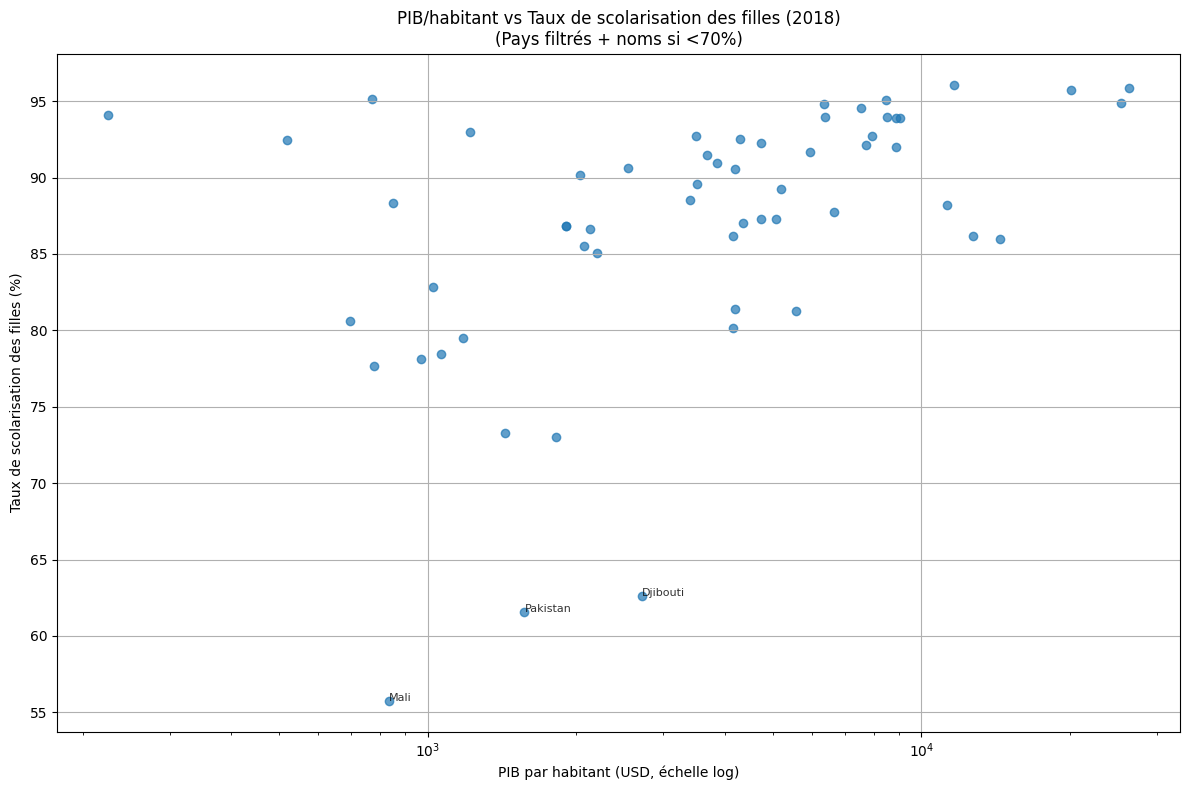

üìà Corr√©lation (2018) : 0.417


In [15]:
# ----------------------------
# 5. Filtrer pour l'ann√©e 2018
# ----------------------------
df_2018 = df_full[df_full["Year"] == 2018]

# ----------------------------
# 6. Filtrer les pays pour lisibilit√©
# ----------------------------
df_2018_filtered = df_2018[
    (df_2018["GDP_per_capita"] < 30000) &
    (df_2018["Enrollment_rate_female"] > 40)
]

# Afficher le nombre de pays restants
print("üìä Pays filtr√©s :", len(df_2018_filtered))

# ----------------------------
# 7. Affichage graphique
# ----------------------------
plt.figure(figsize=(12, 8))

# Scatterplot
plt.scatter(df_2018_filtered["GDP_per_capita"], df_2018_filtered["Enrollment_rate_female"], alpha=0.7)

# Afficher uniquement les noms des pays sous-performants (<70%)
for i, row in df_2018_filtered.iterrows():
    if row["Enrollment_rate_female"] < 70:
        plt.text(row["GDP_per_capita"], row["Enrollment_rate_female"], row["Country Name"],
                 fontsize=8, alpha=0.8)

plt.xscale("log")
plt.title("PIB/habitant vs Taux de scolarisation des filles (2018)\n(Pays filtr√©s + noms si <70%)")
plt.xlabel("PIB par habitant (USD, √©chelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 8. Corr√©lation sur les donn√©es filtr√©es
# ----------------------------
correlation_2018 = df_2018_filtered["GDP_per_capita"].corr(df_2018_filtered["Enrollment_rate_female"])
print("üìà Corr√©lation (2018) :", round(correlation_2018, 3))

## üìà 3. R√©gressions lin√©aires

R√©gression simple (log(PIB) ‚ûù scolarisation) et r√©gression multiple (log(PIB) + d√©penses ‚ûù scolarisation), avec interpr√©tation des coefficients et du R¬≤.

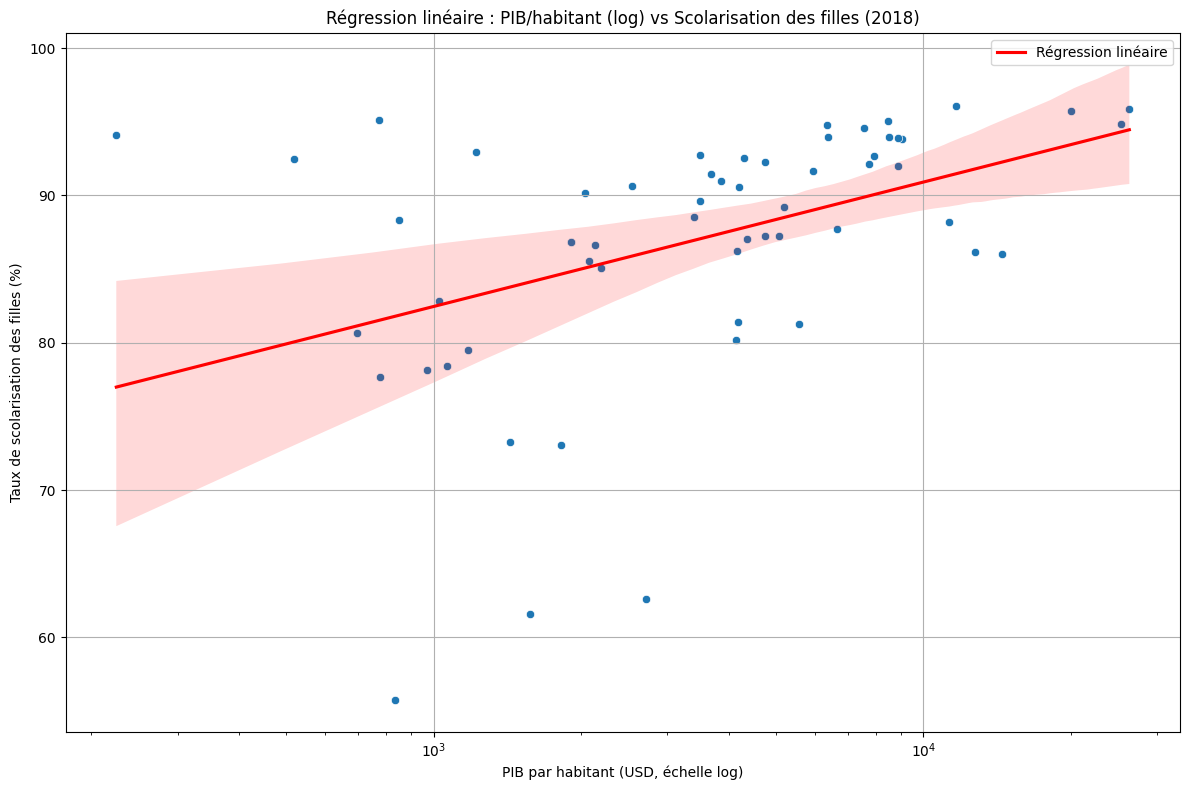

In [16]:
plt.figure(figsize=(12, 8))

# Scatterplot
sns.scatterplot(data=df_2018_filtered, x="GDP_per_capita", y="Enrollment_rate_female")

# R√©gression lin√©aire avec √©chelle logarithmique sur X
line = sns.regplot(data=df_2018_filtered,
                   x="GDP_per_capita", y="Enrollment_rate_female",
                   scatter=False, logx=True,
                   line_kws={"color": "red"})

line_line = line.lines[0]
line_line.set_label("R√©gression lin√©aire")
plt.legend(loc="upper right")

plt.xscale("log")
plt.title("R√©gression lin√©aire : PIB/habitant (log) vs Scolarisation des filles (2018)")
plt.xlabel("PIB par habitant (USD, √©chelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

## üß™ Extension du mod√®le avec une 3e variable et r√©sum√© des analyses pr√©c√©dentes

Avant d'enrichir le mod√®le avec une 3e variable, plusieurs analyses ont √©t√© men√©es :

### üìÖ Analyse 2015 (2 variables)
- **Corr√©lation** entre log(PIB/habitant) et scolarisation : **0.345**
- **R¬≤ de la r√©gression simple :** 0.246

### üìÖ Analyse 2018 (2 variables)
- **Corr√©lation** entre log(PIB/habitant) et scolarisation : **0.418**
- **R¬≤ de la r√©gression simple :** 0.202

> Ces r√©sultats sugg√®rent une corr√©lation positive mod√©r√©e entre richesse et scolarisation, mais aussi une limite dans le pouvoir explicatif du PIB seul.

---

J'ai ensuite cherch√© √† enrichir le mod√®le avec une 3e variable potentiellement influente : **les d√©penses publiques en √©ducation**.

## üìà 4. R√©gression multiple

In [17]:
# Variables explicatives
X = pd.DataFrame({
    "log_GDP_per_capita": np.log(df_2018_filtered["GDP_per_capita"]),
    "public_edu_spending": df_2018_filtered["Public_edu_expenditure_pct_GDP"]
})

# Variable cible
y = df_2018_filtered["Enrollment_rate_female"]

model = LinearRegression()
model.fit(X, y)

# Coefficients
print("üìä Coefficients du mod√®le :")
for name, coef in zip(X.columns, model.coef_):
    print(f"  - {name} : {round(coef, 3)}")

# Ordonn√©e √† l'origine
print("üîÅ Interception :", round(model.intercept_, 3))

# R¬≤ global
r_squared = model.score(X, y)
print("üìê R¬≤ (r√©gression multiple) :", round(r_squared, 3))

üìä Coefficients du mod√®le :
  - log_GDP_per_capita : 3.529
  - public_edu_spending : 1.153
üîÅ Interception : 53.83
üìê R¬≤ (r√©gression multiple) : 0.213


üìå Les r√©sultats chiffr√©s du mod√®le sont jug√©s suffisamment clairs. Aucun graphique n'a √©t√© ajout√© pour la r√©gression multiple afin de pr√©server la lisibilit√© du notebook.

## ‚úÖ 5. Conclusion

Ce projet permet d'aborder en surface et d‚Äôexplorer les facteurs influen√ßant l‚Äô√©ducation des filles √† l‚Äô√©chelle mondiale.

- Le **PIB par habitant** est positivement corr√©l√© √† la scolarisation, mais ne l‚Äôexplique que partiellement.
- L‚Äôajout des **d√©penses publiques en √©ducation** am√©liore le mod√®le, sans toutefois capturer toute la complexit√© du ph√©nom√®ne.

üìå Pour aller plus loin, on pourrait --

- ajouter d'autres ann√©es √† l'analyse pour une comparaison temporelle plus √©tendue,
-  ajouter d'autres variables explicatives (IDH, √©galit√© des genres, stabilit√© politique‚Ä¶),
- mettre en place un syst√®me de pr√©diction supervis√©e (r√©gression multivari√©e avanc√©e).